In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [2]:
class SmartChargeEnv(gym.Env):
    """
    Gym environment for smart charging of electric vehicle.
    The taxi arrives home at 14:00 (step 0) and leaves at 16:00 (step 8).
    At each 15-minute interval, the agent chooses a charging power level.
    The goal is to minimize charging cost and avoid running out of energy.
    """

    def __init__(self,
                 E_max=50.0,            # Maximum battery capacity in kWh
                 p_max=22.0,            # Maximum charging power in kW
                 num_bins=5,           # Discrete power levels
                 mu=30.0, sigma=5.0,    # Demand distribution parameters
                 fail_penalty=1000.0,   # Penalty if energy < demand at departure
                 alpha=None
                ):
        super(SmartChargeEnv, self).__init__()

        # Env parameters
        self.E_max = E_max
        self.p_max = p_max
        self.num_steps = int((16 - 14) * 4)  # 8 time steps of 15 minutes
        self.dt = 0.25  # 15 minutes = 0.25 hours
        self.mu = mu
        self.sigma = sigma
        self.fail_penalty = fail_penalty

        # Default time-varying cost coefficients
        if alpha is None:
            self.alpha = np.linspace(0.1, 0.4, self.num_steps)
        else:
            assert len(alpha) == self.num_steps
            self.alpha = np.array(alpha)

        # Action space: discrete power levels from 0 to p_max
        self.num_bins = num_bins
        self.action_space = spaces.Discrete(self.num_bins)
        # Map integer action -> actual power
        self.power_levels = np.linspace(0, self.p_max, self.num_bins)

        # Observation space: [time_step, energy]
        low = np.array([0.0, 0.0], dtype=np.float32)
        high = np.array([self.num_steps - 1, self.E_max], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Initialize state
        self.state = None  # will hold [time_step, energy]
        self.done = False

    def reset(self):
        """
        Reset the environment to initial state:
          - time_step = 0 (14:00)
          - energy = current charge (assume starting at 0 or user-defined)
        """
        # We start with an empty battery each day
        t0 = 0
        E0 = 0.0
        self.state = np.array([t0, E0], dtype=np.float32)
        self.done = False
        return self.state

    def step(self, action):
        """
        Execute one time step in the environment:
        - Map action index to charging power
        - Update energy with charging, respecting E_max
        - Compute cost = -exp(alpha[t]) * power
        - If final step, sample demand and apply penalty if needed
        - Increment time, check done flag
        """
        t, E = self.state
        t = int(t)

        # Get charging power from action index
        p = float(self.power_levels[action])

        # Update energy
        E_next = min(E + p * self.dt, self.E_max)

        # Charging cost (negative reward)
        cost = -np.exp(self.alpha[t]) * p

        reward = cost

        # Check terminal condition at final time step
        if t == self.num_steps - 1:
            # Sample stochastic demand at departure
            demand = np.random.normal(self.mu, self.sigma)
            # Apply high penalty if battery < demand
            if E_next < demand:
                reward -= self.fail_penalty
            self.done = True

        # 5) Advance time
        t_next = t + 1 if not self.done else t
        self.state = np.array([t_next, E_next], dtype=np.float32)

        info = {"energy": E_next}
        return self.state, reward, self.done, info

    def render(self, mode='human'):
        t, E = self.state
        print(f"Time Step: {int(t)}/{self.num_steps}, Energy: {E:.2f} kWh")


In [3]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class DQNAgent:
    def __init__(self, env, gamma=0.99, alpha=1e-3, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01,
                 buffer_size=10000, batch_size=64, target_update=10):

        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update

        obs_dim = env.observation_space.shape[0]
        n_actions = env.action_space.n

        self.q_net = DQNNetwork(obs_dim, n_actions)
        self.target_net = DQNNetwork(obs_dim, n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=alpha)
        self.loss_fn = nn.MSELoss()

        self.memory = deque(maxlen=buffer_size)
        self.steps = 0

        # Tracking
        self.rewards = []
        self.success_flags = []
        self.episode_penalties = []
        self.episode_end_energy = []


    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return torch.argmax(q_values).item()

    def store(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32))

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.sample_batch()
        q_vals = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_q_vals = self.target_net(next_states).max(1)[0]
            target = rewards + self.gamma * next_q_vals * (1 - dones)

        loss = self.loss_fn(q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

    def train(self, episodes=1000):
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                # --- Action selection ---
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)

                # --- Store transition ---
                self.store((state, action, reward, next_state, float(done)))

                # --- Train from experience ---
                self.update()

                state = next_state
                total_reward += reward
                self.steps += 1

            # === Logging episode info ===
            self.rewards.append(total_reward)

            # Success if no penalty
            penalty_flag = reward < -self.env.fail_penalty / 2
            success_flag = int(not penalty_flag)

            self.success_flags.append(success_flag)
            self.episode_penalties.append(penalty_flag)
            self.episode_end_energy.append(self.env.state[1])  # final energy

            # Epsilon decay
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


            if ep % 10000 == 0:
                print(f"Ep {ep} | Reward: {total_reward:.1f} | Success: {success_flag} | Epsilon: {self.epsilon:.3f}")

    def plot_training(self):
        episodes = np.arange(len(self.rewards))

        plt.figure(figsize=(14, 4))

        # Total reward
        plt.subplot(1, 3, 1)
        plt.plot(episodes, self.rewards, alpha=0.7)
        plt.title("Total Reward per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        # Penalty frequency (moving average)
        plt.subplot(1, 3, 2)
        if len(self.episode_penalties) >= 50:
            penalty_rate = np.convolve(self.episode_penalties, np.ones(50)/50, mode='valid')
            plt.plot(np.arange(len(penalty_rate)), penalty_rate)
        else:
            plt.plot(episodes, self.episode_penalties)
        plt.title("Penalty Frequency (Moving Avg)")
        plt.xlabel("Episode")
        plt.ylabel("Penalty Rate")

        # Final energy at departure
        plt.subplot(1, 3, 3)
        plt.hist(self.episode_end_energy, bins=20, color='skyblue')
        plt.title("Final Battery Energy Distribution")
        plt.xlabel("Energy (kWh)")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

    def summary(self, env):
        total_episodes = len(self.rewards)
        avg_reward = np.mean(self.rewards)
        success_rate = np.mean(self.success_flags)

        print("=== DQN Agent Summary ===")
        print(f"Total Episodes: {total_episodes}")
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Success Rate: {success_rate * 100:.2f}%")
        print(f"Epsilon (final): {self.epsilon:.3f}")
        print()

        # Optionally: run a final greedy episode
        print("Final Episode Greedy Actions (Charging Power):")
        state = env.reset()
        done = False
        step = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_vals = self.q_net(state_tensor)
            action = torch.argmax(q_vals).item()
            power = env.power_levels[action]
            print(f"  Step {step+1}: {power:.2f} kW")
            state, _, done, _ = env.step(action)
            step += 1



    def plot_value_and_policy(self, env, battery_levels=20):
        self.q_net.eval()  # set to evaluation mode

        # Create grid of (time step, battery level) pairs
        time_steps = np.arange(env.num_steps)
        battery_vals = np.linspace(0, env.E_max, battery_levels)
        T, E = np.meshgrid(time_steps, battery_vals)

        V = np.zeros_like(T, dtype=np.float32)
        P = np.zeros_like(T, dtype=np.int32)

        for i in range(T.shape[0]):  # battery level axis
            for j in range(T.shape[1]):  # time step axis
                state = np.array([T[i, j], E[i, j]], dtype=np.float32)
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_vals = self.q_net(state_tensor).squeeze().numpy()
                V[i, j] = np.max(q_vals)
                P[i, j] = np.argmax(q_vals)

        # 1. Value Function 3D Plot
        fig = plt.figure(figsize=(16, 6))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot_surface(T, E, V, cmap='viridis')
        ax1.set_title('DQN: State Value Function V(s)')
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Battery Level (kWh)')
        ax1.set_zlabel('Value')

        # 2. Policy Map
        ax2 = fig.add_subplot(1, 2, 2)
        policy_img = ax2.imshow(P.T, aspect='auto', cmap='tab10',
                                extent=[0, env.num_steps - 1, 0, env.E_max],
                                origin='lower')

        cbar = fig.colorbar(policy_img, ax=ax2, ticks=range(env.num_bins))
        cbar.ax.set_yticklabels([f"{p:.1f} kW" for p in env.power_levels])
        ax2.set_title('DQN Policy Map (Greedy Action)')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Battery Level (kWh)')

        plt.tight_layout()
        plt.show()

        self.q_net.train()

In [16]:
env = SmartChargeEnv(num_bins=5)
agent = DQNAgent(env)

agent.train(episodes=250000)


Ep 0 | Reward: -1157.6 | Success: 0 | Epsilon: 0.995
Ep 10000 | Reward: -204.5 | Success: 1 | Epsilon: 0.010
Ep 20000 | Reward: -200.6 | Success: 1 | Epsilon: 0.010
Ep 30000 | Reward: -210.7 | Success: 1 | Epsilon: 0.010
Ep 40000 | Reward: -195.3 | Success: 1 | Epsilon: 0.010
Ep 50000 | Reward: -213.3 | Success: 1 | Epsilon: 0.010
Ep 60000 | Reward: -205.0 | Success: 1 | Epsilon: 0.010
Ep 70000 | Reward: -210.7 | Success: 1 | Epsilon: 0.010
Ep 80000 | Reward: -204.5 | Success: 1 | Epsilon: 0.010
Ep 90000 | Reward: -203.5 | Success: 1 | Epsilon: 0.010
Ep 100000 | Reward: -210.7 | Success: 1 | Epsilon: 0.010
Ep 110000 | Reward: -227.1 | Success: 1 | Epsilon: 0.010
Ep 120000 | Reward: -195.3 | Success: 1 | Epsilon: 0.010
Ep 130000 | Reward: -221.0 | Success: 1 | Epsilon: 0.010
Ep 140000 | Reward: -218.9 | Success: 1 | Epsilon: 0.010
Ep 150000 | Reward: -202.5 | Success: 1 | Epsilon: 0.010
Ep 160000 | Reward: -227.1 | Success: 1 | Epsilon: 0.010
Ep 170000 | Reward: -227.1 | Success: 1 | Ep

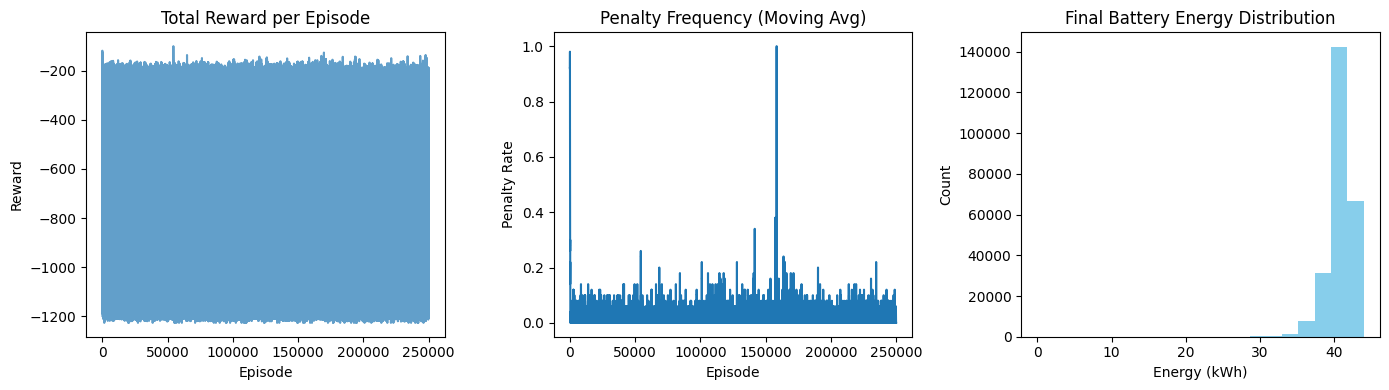

In [17]:
agent.plot_training()

In [18]:
agent.summary(env)

=== DQN Agent Summary ===
Total Episodes: 250000
Average Reward: -232.10
Success Rate: 97.79%
Epsilon (final): 0.010

Final Episode Greedy Actions (Charging Power):
  Step 1: 22.00 kW
  Step 2: 22.00 kW
  Step 3: 22.00 kW
  Step 4: 22.00 kW
  Step 5: 22.00 kW
  Step 6: 22.00 kW
  Step 7: 16.50 kW
  Step 8: 16.50 kW


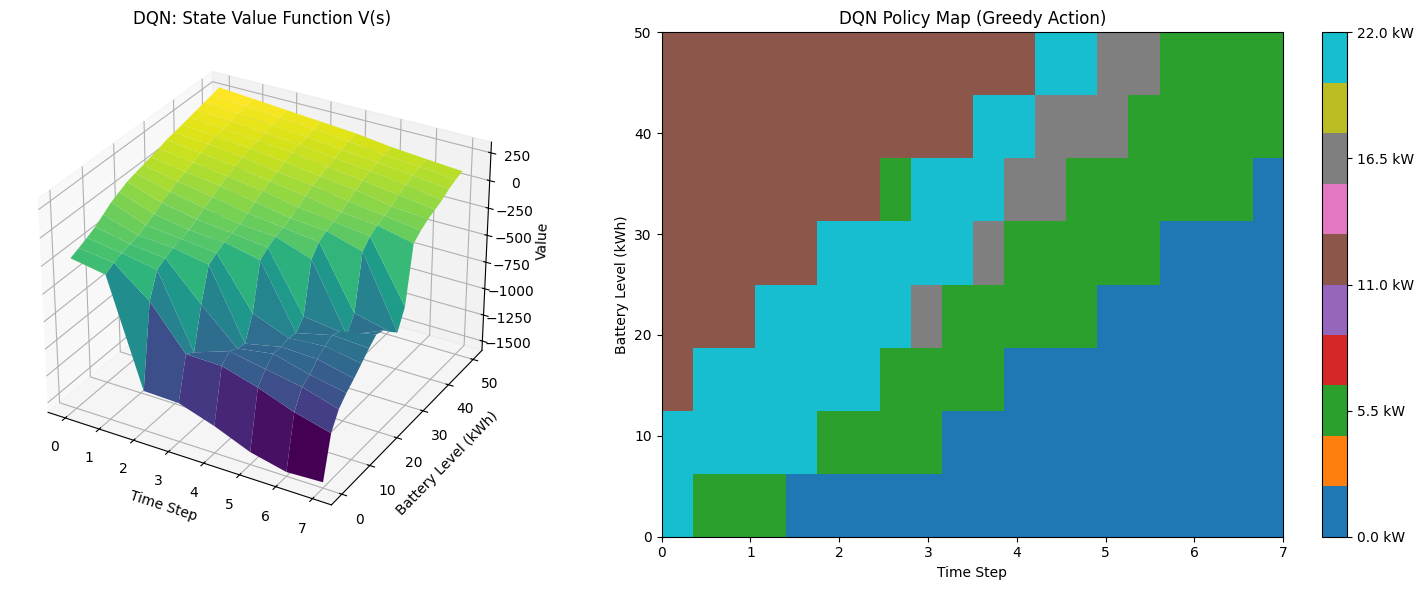

In [19]:
agent.plot_value_and_policy(env)